<h2> <u> CS60075:</u> Natural Language Processing </h2>
<h3> <u>Term Project:</u> Explainable Detection of Online Sexism (EDOS) </h3>

<h6> <u> Group 1 </u>
<ul>
    <li> 19EC10035: Kistamgari Sri Harika Reddy
    <li> 19EC10086: Shruti Shreyasi
    <li> 19EC39007: Bbiswabasu Roy
    <li> 19EC39041: Anik Mandal
    <li> 19EC39044: Ujwal Nitin Nayak
</ul>

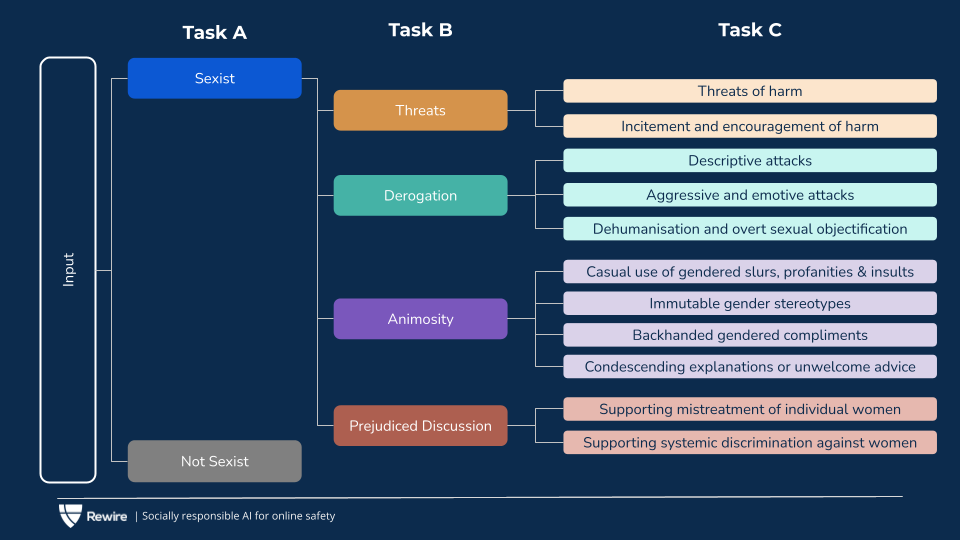

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import f1_score
import os
import nltk
import re
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.tokenize.toktok import ToktokTokenizer

In [ ]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 35.2 MB/s 
     |████████████████████████████████| 7.6 MB 58.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 441 kB 71.5 MB/s 
     |████████████████████████████████| 1.9 MB 49.8 MB/s 
     |████████████████████████████████| 9.2 MB 54.5 MB/s 
     |████████████████████████████████| 43 kB 982 kB/s 
     |████████████████████████████████| 5.5 MB 53.5 MB/s 
     |████████████████████████████████| 163 kB 57.0 MB/s 
     |████████████████████████████████| 182 kB 72.4 MB/s 
     |████████████████████████████████| 168 kB 73.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 166 kB 74.5 MB/s 
     |████████████████████████████████| 166 kB 74.9 MB/s 
     |████████████████████████████████| 162 kB 76.9 MB/s 
     |█████████████████████████████

In [ ]:
import random
torch.manual_seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
!gdown 1O27p0FZniLOE-LpcRPXs5ptHfEWqMAe0
!unzip /content/Project6_Group1.zip

Downloading...
From: https://drive.google.com/uc?id=1O27p0FZniLOE-LpcRPXs5ptHfEWqMAe0
To: /content/Project6_Group1.zip
100% 612k/612k [00:00<00:00, 88.3MB/s]
Archive:  /content/Project6_Group1.zip
  inflating: Group_1/test.csv        
  inflating: Group_1/train.csv       


In [ ]:
train_df = pd.read_csv('./Group_1/train.csv')
train_df.head()

,text,label_sexist,label_category,label_vector
0,"Yes she ducked you over, but its not your chil...",not sexist,none,none
1,"and he holds her arm... geez, there should be ...",not sexist,none,none
2,Lol they can only rail so many women in one ni...,not sexist,none,none
3,How many people buy this lying Yenta Bitch and...,sexist,2. derogation,2.2 aggressive and emotive attacks
4,So is she admitting that women are less mature...,sexist,2. derogation,2.1 descriptive attacks


In [ ]:
def build_datasets(df):
    # removing emojis present in the dataset
    df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    tokenizer=ToktokTokenizer()
    nltk.download('stopwords')
    stopword_list=nltk.corpus.stopwords.words('english')


    def remove_between_square_brackets(text):
        return re.sub('\[[^]]*\]', '', text)

    def denoise_text(text):
        text = remove_between_square_brackets(text)
        return text
    df['text']=df['text'].apply(denoise_text)

    # removing special characters
    def remove_special_characters(text, remove_digits=True):
        pattern=r'[^a-zA-z0-9\s]'
        text=re.sub(pattern,'',text)
        return text
    df['text']=df['text'].apply(remove_special_characters)

    df['text']=df['text'].str.lower()
    df_sexist = df[['text','label_sexist']]
    le_sexist = preprocessing.LabelEncoder()
    le_sexist.fit(df_sexist['label_sexist'])
    df_sexist['label_sexist'] = le_sexist.transform(df_sexist['label_sexist'])
    df_sexist.head()

    df_category = df.loc[df['label_sexist']=='sexist'][['text','label_category']]
    # print(df_category['label_category'].unique())
    le_category = preprocessing.LabelEncoder()
    le_category.fit(df_category['label_category'])
    df_category['label_category'] = le_category.transform(df_category['label_category'])
    df_category.head()

    df_vector = []
    for i in range(1,len(df_category['label_category'].unique())+1):
        df_vector.append(df.loc[df['label_sexist']=='sexist'][
                                        df['label_category'].str.startswith(str(i))][['text','label_vector']])
        # print(df_vector[-1]['label_vector'].unique())
        le_vector = preprocessing.LabelEncoder()
        le_vector.fit(df_vector[-1]['label_vector'])
        df_vector[-1]['label_vector'] = le_vector.transform(df_vector[-1]['label_vector'])
        # print(df_vector[-1]['label_vector'].unique())
    
    return df_sexist, df_category, df_vector

In [ ]:
train_sexist, train_category, train_vector = build_datasets(train_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU')

Tesla T4


In [ ]:
from transformers import BertTokenizer, RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
sentences = [] # list of texts for all models
sentences.append(train_sexist['text'].values)
sentences.append(train_category['text'].values)

for i in range(len(train_vector)):
    sentences.append(train_vector[i]['text'].values)

len(sentences[2])


193

In [ ]:
max_len = 0
# For every dataset
for i in range(len(sentences)):
    print("No of sentences in dataset",i+1,"=",len(sentences[i]))
    for sent in sentences[i]:
        max_len = max(max_len, len(input_ids))
print('Max length: ', max_len)

No of sentences in dataset 1 = 8000
No of sentences in dataset 2 = 1975
No of sentences in dataset 3 = 193
No of sentences in dataset 4 = 927
No of sentences in dataset 5 = 660
No of sentences in dataset 6 = 195
Max length:  68


In [ ]:
input_ids = []
attention_masks = []
label = []

# For every dataset
for i in range(len(sentences)):
    input_ids.append([])
    attention_masks.append([])
    # For every sentence
    for sent in sentences[i]:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 68,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                        )

        input_ids[i].append(encoded_dict['input_ids'])
        attention_masks[i].append(encoded_dict['attention_mask'])
        
    input_ids[i] = torch.cat(input_ids[i], dim=0)
    attention_masks[i] = torch.cat(attention_masks[i], dim=0)
    if i==0:
        label.append(torch.tensor(train_sexist['label_sexist'].values))
    elif i==1:
        label.append(torch.tensor(train_category['label_category'].values))
    else:
        label.append(torch.tensor(train_vector[i-2]['label_vector'].values))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset, train_size, val_size, train_dataset, val_dataset = [],[],[],[],[]
for i in range(len(sentences)):
    dataset.append(TensorDataset(input_ids[i], attention_masks[i], label[i]))
    train_size.append(int(0.9 * len(dataset[i])))
    val_size.append(len(dataset[i]) - train_size[i])
    tr_vl_split = random_split(dataset[i], [train_size[i], val_size[i]])
    train_dataset.append(tr_vl_split[0])
    val_dataset.append(tr_vl_split[1]) 

    print('{:>5,} training samples'.format(train_size[i]))
    print('{:>5,} validation samples'.format(val_size[i]))

7,200 training samples
  800 validation samples
1,777 training samples
  198 validation samples
  173 training samples
   20 validation samples
  834 training samples
   93 validation samples
  594 training samples
   66 validation samples
  175 training samples
   20 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader, validation_dataloader = [],[]
for i in range(len(sentences)):
    train_dataloader.append(DataLoader(
                train_dataset[i],
                sampler = RandomSampler(train_dataset[i]),
                batch_size = batch_size
            ))

    validation_dataloader.append(DataLoader(
                val_dataset[i],
                sampler = SequentialSampler(val_dataset[i]),
                batch_size = batch_size 
            ))


In [ ]:
from transformers import BertForSequenceClassification,RobertaForSequenceClassification, AdamW, BertConfig

model = []
num_labels = [2,4,2,3,4,2]
for i in range(len(sentences)):
    model.append(RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels = num_labels[i],
        output_attentions = False,
        output_hidden_states = False,
        ))

    model[i].cuda()


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
optimizer = []
for i in range(len(sentences)):
    optimizer.append(AdamW(model[i].parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                ))


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps, scheduler = [],[]
for i in range(len(sentences)):
    total_steps.append(len(train_dataloader[i]) * epochs)

    scheduler.append(get_linear_schedule_with_warmup(optimizer[i], 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps[i]))


In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat,labels_flat,average="macro")


In [ ]:
import random
import numpy as np


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

for i in range(len(sentences)):
    training_stats = []


    for epoch_i in range(0, epochs):
        
        # Training

        print("")
        print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
        print('Training...')


        total_train_loss = 0

        model[i].train()

        for step, batch in enumerate(train_dataloader[i]):

            if step % 40 == 0 and not step == 0:
                print('  Batch {:>5,}  of  {:>5,}'.format(step, len(train_dataloader[i])))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model[i].zero_grad()        

            loss, logits = model[i](b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)[0:2]
    #         print((model(b_input_ids, 
    #                              token_type_ids=None, 
    #                              attention_mask=b_input_mask, 
    #                              labels=b_labels)))
            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model[i].parameters(), 1.0)

            optimizer[i].step()

            scheduler[i].step()

        avg_train_loss = total_train_loss / len(train_dataloader[i])            
        
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
            
        # Validation

        print("")
        print("Validation...")


        model[i].eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader[i]:
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():        

                loss, logits = model[i](b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)[0:2]
                
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader[i])
        print("  F1 score: {0:.2f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(validation_dataloader[i])
                
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
            }
        )



Epoch 1 / 4
Training...
  Batch    40  of    225
  Batch    80  of    225
  Batch   120  of    225
  Batch   160  of    225
  Batch   200  of    225

  Average training loss: 0.44

Validation...
  F1 score: 0.79
  Validation Loss: 0.37

Epoch 2 / 4
Training...
  Batch    40  of    225
  Batch    80  of    225
  Batch   120  of    225
  Batch   160  of    225
  Batch   200  of    225

  Average training loss: 0.31

Validation...
  F1 score: 0.74
  Validation Loss: 0.36

Epoch 3 / 4
Training...
  Batch    40  of    225
  Batch    80  of    225
  Batch   120  of    225
  Batch   160  of    225
  Batch   200  of    225

  Average training loss: 0.23

Validation...
  F1 score: 0.80
  Validation Loss: 0.36

Epoch 4 / 4
Training...
  Batch    40  of    225
  Batch    80  of    225
  Batch   120  of    225
  Batch   160  of    225
  Batch   200  of    225

  Average training loss: 0.17

Validation...
  F1 score: 0.79
  Validation Loss: 0.40

Epoch 1 / 4
Training...
  Batch    40  of     56

 

In [ ]:
for i in range(len(sentences)):
    model_to_save = model[i].module if hasattr(model[i], 'module') else model[i]
    model_to_save.save_pretrained('./model_saves_'+str(i))
    tokenizer.save_pretrained('./model_saves_'+str(i))

In [ ]:
train_df = pd.read_csv('./Group_1/train.csv')
train_df.head()

,text,label_sexist,label_category,label_vector
0,"Yes she ducked you over, but its not your chil...",not sexist,none,none
1,"and he holds her arm... geez, there should be ...",not sexist,none,none
2,Lol they can only rail so many women in one ni...,not sexist,none,none
3,How many people buy this lying Yenta Bitch and...,sexist,2. derogation,2.2 aggressive and emotive attacks
4,So is she admitting that women are less mature...,sexist,2. derogation,2.1 descriptive attacks


In [ ]:
mapping_vector, mapping, mapping_category = {}, {}, {}
mapping_vector_inv, mapping_inv, mapping_category_inv = {}, {}, {}

le_sexist = preprocessing.LabelEncoder()
le_sexist.fit(train_df['label_sexist'])
for i in train_df['label_sexist']:
    mapping[le_sexist.transform([i])[0]] = i
    mapping_inv[i] = le_sexist.transform([i])[0]
train_df['label_sexist'] = le_sexist.fit_transform(train_df['label_sexist'])

le_category = preprocessing.LabelEncoder()
le_category.fit(train_df['label_category'])
for i in train_df['label_category']:
    mapping_category[le_category.transform([i])[0]] = i
    mapping_category_inv[i] = le_category.transform([i])[0]
train_df['label_category'] = le_category.fit_transform(train_df['label_category'])

le_vector = preprocessing.LabelEncoder()
le_vector.fit(train_df['label_vector'])
for i in train_df['label_vector']:
    mapping_vector[le_vector.transform([i])[0]] = i
    mapping_vector_inv[i] = le_vector.transform([i])[0]
train_df['label_vector'] = le_vector.fit_transform(train_df['label_vector'])

In [ ]:
tt = train_df[train_df.label_sexist == mapping_inv['sexist']]
train_data_cat = pd.DataFrame({
    'text': tt['text'].replace(r'\n', ' ', regex=True),
    'labels':tt['label_vector']
})

In [ ]:
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "evaluate_during_training": False,
    "max_seq_length": 128,
    "num_train_epochs": 20,
    "evaluate_during_training_steps": 1000,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "train_batch_size": 128,
    "eval_batch_size": 64,
    "output_dir": f"outputs/roberta",
    "best_model_dir": f"outputs/roberta/best_model"
}

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs = 20)
model11 = ClassificationModel('roberta', 'roberta-base', num_labels = 11, args=model_args)
model11.train_model(train_data_cat, args=train_args)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/1975 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/16 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# import pickle 
# output = open('/content/encoder_dict/sexist_encoder.pkl', 'wb')
# pickle.dump(le_sexist, output)
# output.close()
# output = open('/content/encoder_dict/category_encoder.pkl', 'wb')
# pickle.dump(le_category, output)
# output.close()
# output = open('/content/encoder_dict/vector_encoder.pkl', 'wb')
# pickle.dump(le_vector, output)
# output.close()
# output = open('/content/encoder_dict/inv_map.pkl', 'wb')
# pickle.dump(mapping_inv, output)
# output.close()

In [ ]:
# import shutil
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_0', 'zip', '/content/model_saves_0')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_1', 'zip', '/content/model_saves_1')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_2', 'zip', '/content/model_saves_2')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_3', 'zip', '/content/model_saves_3')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_4', 'zip', '/content/model_saves_4')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_5', 'zip', '/content/model_saves_5')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/model_saves_6', 'zip', '/content/outputs')
# shutil.make_archive('/content/gdrive/MyDrive/NLP_Term_Project_Files/encoder_dict', 'zip', '/content/encoder_dict')

Evaluation

Downloading and installing all packages and files required to run the evaluation script

In [ ]:
!pip install simpletransformers
!gdown 1O27p0FZniLOE-LpcRPXs5ptHfEWqMAe0
!gdown 1-HPrgFQL2uajJ3RuV0rQKFjKeeOqu1wq
!gdown 1-X6MGj_v51JKOHtfdKCJR-2zl2QTT4SG
!gdown 1-ahXX52-9pMGarzhh0UOfPh8aN8M8r2C
!gdown 1-d1b6lES1gFwcTivTkI_TopOJ_YlkwIZ
!gdown 1-gRF5fDpLTOWI5QtPsk_RmSC6yJSqEr-
!gdown 1-uARsLo2dQnlnkNhpPIw62JkMvKOHOpb
!gdown 1XSiDmQV0nMjfNNHebrCML9qG4V2oJqC1
!gdown 1-0rjFsVAOVCJQhvU3_L5eMCHkKIvc4sX
!gdown 1-9f69p601qL3uJv3MutZMjsrRYEure97
!unzip /content/Project6_Group1.zip
!unzip /content/model_saves_0.zip -d model_saves_0
!unzip /content/model_saves_1.zip -d model_saves_1
!unzip /content/model_saves_2.zip -d model_saves_2
!unzip /content/model_saves_3.zip -d model_saves_3
!unzip /content/model_saves_4.zip -d model_saves_4
!unzip /content/model_saves_5.zip -d model_saves_5
!unzip /content/model_saves_6.zip -d model_saves_6
!unzip /content/encoder_dict.zip -d encoder_dict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 30.0 MB/s 
     |████████████████████████████████| 7.6 MB 59.5 MB/s 
     |████████████████████████████████| 1.9 MB 63.0 MB/s 
     |████████████████████████████████| 441 kB 65.0 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 9.2 MB 57.3 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 5.5 MB 64.1 MB/s 
     |████████████████████████████████| 163 kB 71.3 MB/s 
     |████████████████████████████████| 182 kB 66.7 MB/s 
     |████████████████████████████████| 168 kB 74.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 70.4 MB/s 
     |████████████████████████████████| 166 kB 70.5 MB/s 
     |████████████████████████████████| 162 kB 73.4 MB/s 
     |█████████████████████████████

In [ ]:
!python eval.py

GPU: Tesla T4
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassifica